In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [5]:
! pip install -q --upgrade pip
! pip install -q matplotlib
!pip install -q torchsummary

In [6]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [7]:
train = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [8]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


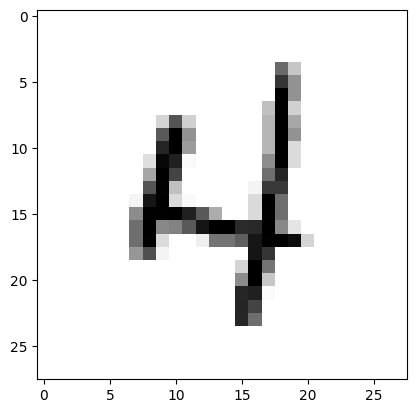

In [9]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


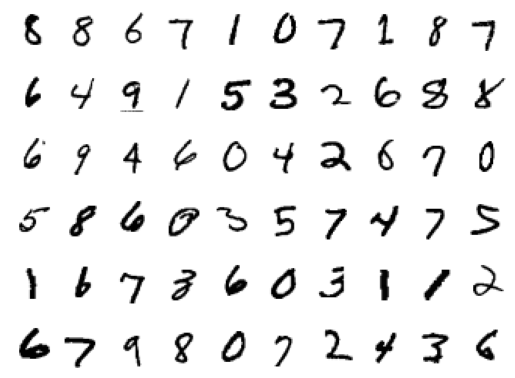

In [10]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [11]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


In [12]:
from src.models import models

In [23]:
model = models.NetBasic().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

In [18]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [24]:
model =  models.NetBasic().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.09188923984766006 Batch_id=468 Accuracy=87.25: 100%|██████████| 469/469 [00:09<00:00, 47.55it/s] 



Test set: Average loss: 0.0683, Accuracy: 9782/10000 (97.82%)

EPOCH: 1


Loss=0.05370994284749031 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:09<00:00, 47.23it/s]  



Test set: Average loss: 0.0383, Accuracy: 9869/10000 (98.69%)

EPOCH: 2


Loss=0.01965545304119587 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:09<00:00, 47.18it/s]  



Test set: Average loss: 0.0311, Accuracy: 9894/10000 (98.94%)

EPOCH: 3


Loss=0.023096129298210144 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:09<00:00, 47.56it/s] 



Test set: Average loss: 0.0299, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.023194538429379463 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:09<00:00, 47.26it/s]  



Test set: Average loss: 0.0249, Accuracy: 9917/10000 (99.17%)

EPOCH: 5


Loss=0.007711999583989382 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:10<00:00, 46.85it/s]  



Test set: Average loss: 0.0248, Accuracy: 9916/10000 (99.16%)

EPOCH: 6


Loss=0.00872092880308628 Batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:10<00:00, 46.57it/s]   



Test set: Average loss: 0.0370, Accuracy: 9889/10000 (98.89%)

EPOCH: 7


Loss=0.03086322359740734 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:09<00:00, 47.26it/s]   



Test set: Average loss: 0.0315, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Loss=0.0005823676474392414 Batch_id=468 Accuracy=99.78: 100%|██████████| 469/469 [00:09<00:00, 46.94it/s] 



Test set: Average loss: 0.0325, Accuracy: 9903/10000 (99.03%)

EPOCH: 9


Loss=0.0009694052278064191 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:09<00:00, 47.22it/s] 



Test set: Average loss: 0.0301, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=6.10917413723655e-05 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:09<00:00, 47.12it/s]  



Test set: Average loss: 0.0307, Accuracy: 9915/10000 (99.15%)

EPOCH: 11


Loss=0.018711745738983154 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:09<00:00, 47.40it/s]  



Test set: Average loss: 0.0296, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=2.9649898351635784e-05 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:10<00:00, 46.76it/s]



Test set: Average loss: 0.0287, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.024672990664839745 Batch_id=468 Accuracy=99.92: 100%|██████████| 469/469 [00:09<00:00, 47.18it/s]  



Test set: Average loss: 0.0312, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.0003266339481342584 Batch_id=468 Accuracy=99.91: 100%|██████████| 469/469 [00:10<00:00, 46.64it/s] 



Test set: Average loss: 0.0301, Accuracy: 9926/10000 (99.26%)



Text(0.5, 1.0, 'Test Accuracy')

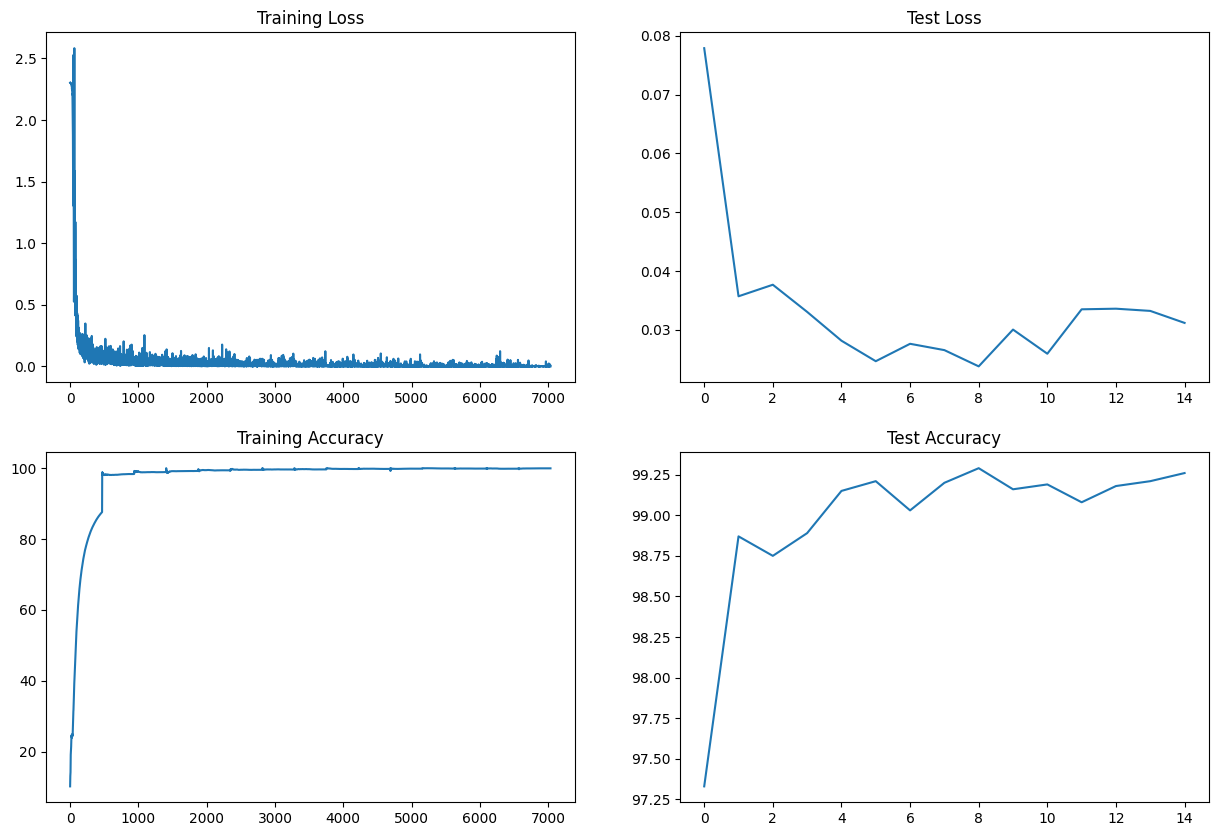

In [22]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target
- Get the set-up right
- Set Transforms
- Set Data Loader
- Set Basic Working Code
- Set Basic Training & Test Loop

## Results
- **Parameters:** 6.3M
- **Best Training Accuracy:** 99.91
- **Best Test Accuracy:** 99.26

## Analysis
- Extremely Heavy Model for such a problem
- Model is over-fitting, but we are changing our model in the next step
